In [1]:
### Topo cross section and displacement swath profiles

# steps

# 0: load dependencies
# 1: Define functions
# 2: load data
# 3: define swath profiles
# 4: load topo data, disp data from swath
# 5: calculate median topography per band
# 6: calculate statistics of displacement per band
# 7: plot results


In [2]:
# load dependencies

## first time series test
# append ../../ to make link to main repo work
import sys
sys.path.append('../../')
sys.path.append('/Applications/anaconda3/envs/PhD_clean/lib/python3.11/site-packages/')


# import external packages
import numpy as np
import pandas as pd
import numba
from numba import vectorize
import glob # for file search
import copy
import os # operating system stuff
import re # regex


import geopandas as gpd
import rasterio as rio
import rasterio.mask
from rasterio.plot import plotting_extent
# import rioxarray
from shapely.geometry import Polygon
from shapely.geometry.point import Point
import pyproj
from pyproj import CRS
from inpoly import inpoly2 # for fast inpolygon checks
import utm

import matplotlib.pyplot as plt 
import matplotlib.dates as mdates
from matplotlib import cm as mpl_cm
from matplotlib import colors as mcolors 
import matplotlib.image as mplimg

from mpl_toolkits.axes_grid1 import make_axes_locatable # for colorbar scaling
from mpl_toolkits.axes_grid1 import ImageGrid
from matplotlib_scalebar.scalebar import ScaleBar
from matplotlib.gridspec import GridSpec
from matplotlib.ticker import FormatStrFormatter

import seaborn as sns
from matplotlib import rc_file_defaults
rc_file_defaults()
# sns.set(style=None, color_codes=True)

from shapely.geometry import Polygon
from shapely.geometry.point import Point
import datetime

import configparser

from cmcrameri import cm # for scientific colourmaps

from scipy import spatial
# from scikit_spatial import Line as sksline
# import scipy.spatial.transform 

from skspatial.objects import Line as sksline
import scipy.spatial.transform 

import json
from shapely.geometry import Point, LineString, mapping
from functools import partial
from shapely.ops import transform

import sys
sys.executable


###########################
# import main local package
import SPOTSAR_main as sm



In [10]:
# define functions

import matplotlib.patches as mpatches
import matplotlib.transforms as mtransforms
def add_bottom_cax(ax, pad, height):
    axpos = ax.get_position()
    caxpos = mtransforms.Bbox.from_extents(
        axpos.x0,
        axpos.y0 - pad - height,
        axpos.x1,
        axpos.y0 - pad
    )
    cax = ax.figure.add_axes(caxpos)

    return cax

## swath profile

def poly_line_buffer_lat_lon(line_coords,width):
    line = LineString(line_coords)
    local_azimuthal_projection = f"+proj=aeqd +R=6371000 +units=m +lat_0={line.coords[0][1]} +lon_0={line.coords[0][0]}"

    wgs84_to_aeqd = partial(
            pyproj.transform,
            pyproj.Proj('+proj=longlat +datum=WGS84 +no_defs'),
            pyproj.Proj(local_azimuthal_projection),
            )

    aeqd_to_wgs84 = partial(
            pyproj.transform,
            pyproj.Proj(local_azimuthal_projection),
            pyproj.Proj('+proj=longlat +datum=WGS84 +no_defs'),
            )
    line_transformed = transform(wgs84_to_aeqd, line)
    buffer_line = line_transformed.buffer(width/2,cap_style=2)# capstyle 2 for flat caps the meet profile (so do not go beyond the line)
    return transform(aeqd_to_wgs84, buffer_line)

import contextlib
import shapely
import warnings
from distutils.version import LooseVersion

SHAPELY_GE_20 = str(shapely.__version__) >= LooseVersion("2.0")

try:
    from shapely.errors import ShapelyDeprecationWarning as shapely_warning
except ImportError:
    shapely_warning = None

if shapely_warning is not None and not SHAPELY_GE_20:
    @contextlib.contextmanager
    def ignore_shapely2_warnings():
        with warnings.catch_warnings():
            warnings.filterwarnings("ignore", category=shapely_warning)
            yield
else:
    @contextlib.contextmanager
    def ignore_shapely2_warnings():
        yield

def geodetic2enu(lat, lon, alt, lat_org, lon_org, alt_org):
    transformer = pyproj.Transformer.from_crs(
        {"proj":'latlong', "ellps":'WGS84', "datum":'WGS84'},
        {"proj":'geocent', "ellps":'WGS84', "datum":'WGS84'},
        )
    x, y, z = transformer.transform( lon,lat,  alt,radians=False)
    x_org, y_org, z_org = transformer.transform( lon_org,lat_org,  alt_org,radians=False)
    vec=np.array([[ x-x_org, y-y_org, z-z_org]]).T
    
    rot1 =  scipy.spatial.transform.Rotation.from_euler('x', -(90-lat_org), degrees=True).as_matrix()#angle*-1 : left handed *-1
    rot3 =  scipy.spatial.transform.Rotation.from_euler('z', -(90+lon_org), degrees=True).as_matrix()#angle*-1 : left handed *-1
    rotMatrix = rot1.dot(rot3)  
    
    enu = np.squeeze(rotMatrix.dot(vec).T)
    return enu



def get_swath_profile(data,lons,lats,start,end,width=25,dx=10,):
    """ Calculate swarth profile for gridded or 1-d array data with known longitude,latitude coordinates.


    Arguments:
        data  (np.array)        : Data from which swath profile is taken.
        lon   (np.array)        : Longitude of the data.
        lat   (np.array)        : Latitude of data.
        start (np.array-like)   : (longitude, latitude) of start point of swath profile
        end   (np.array-like)   : (longitude, latitude) of end point of swath profile
        width (float or int)    : (optional) width of swarth profile in meters, defaults to 25
        dx    (float or int)    : (optional) along profile discretisation in meters, detaults to 10 m

    Return:
        proj_data     (np.array)      : array containing, longitude, latitude, distance along profile, data
        profile_stats (np.array)      : array containing distance along profile, mean, median, 2.5 percentile, 97.5 percentile
    """

    # define swath profile centre line
    line = sksline.from_points(point_a=start, point_b=end)
    line_coords = np.asarray([start,end])
    buffer_poly = poly_line_buffer_lat_lon(line_coords,width)

    # stack lon and lat
    lon_lat = np.dstack((lons,lats))

    # get data within swath profile
    isin, ison = inpoly2(np.squeeze(lon_lat),np.asarray(buffer_poly.exterior.coords))
    print(f'number of points in swath profile: {np.count_nonzero(isin)}')
    proj_point = np.empty(shape=(np.count_nonzero(isin), 3), dtype=float) # pre-alloc nd-array 

    with ignore_shapely2_warnings():
        for p_id, lon_lat_id in enumerate(zip(np.squeeze(lon_lat)[isin,:],data.flatten()[isin])):
            point = lon_lat_id[0]
            proj_point[p_id,:]=np.append(np.asarray(line.project_point(point)),lon_lat_id[1])

    # transform projected points to east,north,(up)
    point_transformed = geodetic2enu(proj_point[:,1],
                                    proj_point[:,0],
                                    np.squeeze(np.zeros((np.count_nonzero(isin),1))).T,
                                    start[1],
                                    start[0],
                                    0)
    
    #lon,lat,dist along profile, data
    proj_data      = np.stack((proj_point[:,0], 
                            proj_point[:,1],
                            np.linalg.norm(point_transformed[:,0:2],axis=1),
                            proj_point[:,2])).T


    # calculate statistics along swath profile with sections of length dx
    max_dist = proj_data[:,2].max()
    edges = np.arange(0,max_dist,dx)
    profile_stats = np.empty(shape=(edges.shape[0]-1, 5), dtype=float) # pre-alloc nd-array
    for bin_id in enumerate(edges[:-1]):
        sel = np.squeeze(np.asarray([(proj_data[:,2]>=edges[bin_id[0]]) & (proj_data[:,2]<=edges[bin_id[0]+1])]))
        profile_stats[bin_id[0],:] = [bin_id[1]+dx/2,
                                      np.nanmean(proj_data[sel,3]),
                                      np.nanmedian(proj_data[sel,3]),
                                      np.nanpercentile(proj_data[sel,3],2.5),
                                      np.nanpercentile(proj_data[sel,3],97.5)]

    return proj_data, profile_stats



/var/folders/7b/9xvft5dd0455jpkm_r7rgr3w0000gp/T/ipykernel_46242/3304836431.py:43: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  SHAPELY_GE_20 = str(shapely.__version__) >= LooseVersion("2.0")


In [4]:
# ## swath profile

# def poly_line_buffer_lat_lon(line_coords,width):
#     line = LineString(line_coords)
#     local_azimuthal_projection = f"+proj=aeqd +R=6371000 +units=m +lat_0={line.coords[0][1]} +lon_0={line.coords[0][0]}"

#     wgs84_to_aeqd = partial(
#             pyproj.transform,
#             pyproj.Proj('+proj=longlat +datum=WGS84 +no_defs'),
#             pyproj.Proj(local_azimuthal_projection),
#             )

#     aeqd_to_wgs84 = partial(
#             pyproj.transform,
#             pyproj.Proj(local_azimuthal_projection),
#             pyproj.Proj('+proj=longlat +datum=WGS84 +no_defs'),
#             )
#     line_transformed = transform(wgs84_to_aeqd, line)
#     buffer_line = line_transformed.buffer(width/2,cap_style=2)# capstyle 2 for flat caps the meet profile (so do not go beyond the line)
#     return transform(aeqd_to_wgs84, buffer_line)


In [5]:
# ## error/warning suppresion

# import contextlib
# import shapely
# import warnings
# from distutils.version import LooseVersion

# SHAPELY_GE_20 = str(shapely.__version__) >= LooseVersion("2.0")

# try:
#     from shapely.errors import ShapelyDeprecationWarning as shapely_warning
# except ImportError:
#     shapely_warning = None

# if shapely_warning is not None and not SHAPELY_GE_20:
#     @contextlib.contextmanager
#     def ignore_shapely2_warnings():
#         with warnings.catch_warnings():
#             warnings.filterwarnings("ignore", category=shapely_warning)
#             yield
# else:
#     @contextlib.contextmanager
#     def ignore_shapely2_warnings():
#         yield

In [6]:
### load data

# load SPOT time-series data
# CSK
CSK_TS_FILE = '/Users/tz20896/Documents/PhD/projects/Merapi2021/CSK/dsc1/CSK_SPOT_dsc_win13_ts_inv.csv'
CSK_TS = pd.read_csv(CSK_TS_FILE)
# TSX
TSX_TS_FILE = '/Users/tz20896/Documents/PhD/projects/Merapi2021/TSX/staring_134/TSX_ST134_win13_ts_inv.csv'
TSX_TS = pd.read_csv(TSX_TS_FILE)

# show TS data

print(CSK_TS)
print(TSX_TS)

col_offset = 3
CSK_R_disp_1 = (CSK_TS.iloc[:,col_offset+5 *2] - CSK_TS.iloc[:,col_offset+0*2])
CSK_R_disp_2 = (CSK_TS.iloc[:,col_offset+13*2] - CSK_TS.iloc[:,col_offset +5*2])
CSK_R_disp_3 = (CSK_TS.iloc[:,col_offset+37*2] - CSK_TS.iloc[:,col_offset+13*2])
CSK_R_disp_4 = (CSK_TS.iloc[:,col_offset+42*2] - CSK_TS.iloc[:,col_offset+37*2])
CSK_R_disp_5 = (CSK_TS.iloc[:,col_offset+54*2] - CSK_TS.iloc[:,col_offset+42*2])

CSK_A_disp_1 = (CSK_TS.iloc[:,col_offset+5 *2+1] - CSK_TS.iloc[:,col_offset+0*2+1])
CSK_A_disp_2 = (CSK_TS.iloc[:,col_offset+13*2+1] - CSK_TS.iloc[:,col_offset +5*2+1])
CSK_A_disp_3 = (CSK_TS.iloc[:,col_offset+37*2+1] - CSK_TS.iloc[:,col_offset+13*2+1])
CSK_A_disp_4 = (CSK_TS.iloc[:,col_offset+42*2+1] - CSK_TS.iloc[:,col_offset+37*2+1])
CSK_A_disp_5 = (CSK_TS.iloc[:,col_offset+54*2+1] - CSK_TS.iloc[:,col_offset+42*2+1])

CSK_Mag_1 = np.hypot(CSK_A_disp_1,CSK_R_disp_1)
CSK_Mag_2 = np.hypot(CSK_A_disp_2,CSK_R_disp_2)
CSK_Mag_3 = np.hypot(CSK_A_disp_3,CSK_R_disp_3)
CSK_Mag_4 = np.hypot(CSK_A_disp_4,CSK_R_disp_4)
CSK_Mag_5 = np.hypot(CSK_A_disp_5,CSK_R_disp_5)



TSX_R_disp_2 = (TSX_TS.iloc[:,col_offset+4*2] - TSX_TS.iloc[:,col_offset +0*2])
TSX_R_disp_3 = (TSX_TS.iloc[:,col_offset+12*2] - TSX_TS.iloc[:,col_offset+4*2])
TSX_R_disp_4 = (TSX_TS.iloc[:,col_offset+13*2] - TSX_TS.iloc[:,col_offset+12*2])
TSX_R_disp_5 = (TSX_TS.iloc[:,col_offset+14*2] - TSX_TS.iloc[:,col_offset+13*2])


TSX_A_disp_2 = (TSX_TS.iloc[:,col_offset+4*2+1] - TSX_TS.iloc[:,col_offset +0*2+1])
TSX_A_disp_3 = (TSX_TS.iloc[:,col_offset+12*2+1] - TSX_TS.iloc[:,col_offset+4*2+1])
TSX_A_disp_4 = (TSX_TS.iloc[:,col_offset+13*2+1] - TSX_TS.iloc[:,col_offset+12*2+1])
TSX_A_disp_5 = (TSX_TS.iloc[:,col_offset+14*2+1] - TSX_TS.iloc[:,col_offset+13*2+1])


TSX_Mag_2 = np.hypot(TSX_A_disp_2,TSX_R_disp_2)
TSX_Mag_3 = np.hypot(TSX_A_disp_3,TSX_R_disp_3)
TSX_Mag_4 = np.hypot(TSX_A_disp_4,TSX_R_disp_4)
TSX_Mag_5 = np.hypot(TSX_A_disp_5,TSX_R_disp_5)

# DEM
Merapi_DEM_file = "/Users/tz20896/Documents/PhD/projects/Merapi2021/geo/TDX_Merapi_WGS84_5m.tif"
with rio.open(Merapi_DEM_file) as img:
    DEM = img.read(1,masked=True) # rasterio bands are indexed from 1
    # extract DEM extent
    DEM_extent=[img.bounds.left,img.bounds.right,img.bounds.bottom,img.bounds.top]
    print('Band1 has shape', DEM.shape)
    height = DEM.shape[0]
    width  = DEM.shape[1]
    cols, rows = np.meshgrid(np.arange(width), np.arange(height))
    xs, ys = rio.transform.xy(img.transform, rows, cols)
    lons_DEM = np.array(xs)
    lats_DEM = np.array(ys)


# DEM
Merapi_HS_file = "/Users/tz20896/Documents/PhD/projects/Merapi2021/geo/TDX_Merapi_WGS84_HS.tif"
with rio.open(Merapi_HS_file) as img:
    SHADING = img.read(1,masked=True) # rasterio bands are indexed from 1




# lava flow files:
L1888_FILE  = '/Users/tz20896/Documents/PhD/projects/Merapi2021/merapi_maps/L1888_v2.shp'
L1948_FILE  = '/Users/tz20896/Documents/PhD/projects/Merapi2021/merapi_maps/L1948.shp'
L1956_FILE  = '/Users/tz20896/Documents/PhD/projects/Merapi2021/merapi_maps/L1956.shp'
L1992_FILE  = '/Users/tz20896/Documents/PhD/projects/Merapi2021/merapi_maps/L1992.shp'
L1997_FILE  = '/Users/tz20896/Documents/PhD/projects/Merapi2021/merapi_maps/L1997.shp'
L1998_FILE  = '/Users/tz20896/Documents/PhD/projects/Merapi2021/merapi_maps/L1998.shp'
CRATER_FILE = '/Users/tz20896/Documents/PhD/projects/Merapi2021/merapi_maps/Merapi_crater.shp'

# Read the shapefile
L1888  = gpd.read_file(L1888_FILE)
L1948  = gpd.read_file(L1948_FILE)
L1956  = gpd.read_file(L1956_FILE)
L1992  = gpd.read_file(L1992_FILE)
L1997  = gpd.read_file(L1997_FILE)
L1998  = gpd.read_file(L1998_FILE)
CRATER = gpd.read_file(CRATER_FILE)

# Extract latitude and longitude into separate columns
coords_L1888   = np.array(list(L1888 ["geometry"][0].coords))
coords_L1956_1 = np.array(list(L1956 ["geometry"][0].coords))
coords_L1956_2 = np.array(list(L1956 ["geometry"][1].coords))
coords_L1948   = np.array(list(L1948 ["geometry"][0].coords))
coords_L1992   = np.array(list(L1992 ["geometry"][0].coords))
coords_L1997   = np.array(list(L1997 ["geometry"][0].coords))
coords_L1998   = np.array(list(L1998 ["geometry"][0].coords))
coords_CRATER  = np.array(list(CRATER["geometry"][0].coords))

        Unnamed: 0   Longitude  Latitude  r_disp_  a_disp_  r_disp_20200910  \
0                0  110.483566 -7.519673      0.0      0.0        -0.081862   
1                1  110.483627 -7.519764      0.0      0.0        -0.110186   
2                2  110.483574 -7.519828      0.0      0.0        -0.116883   
3                3  110.483536 -7.519897      0.0      0.0        -0.141539   
4                4  110.483505 -7.519970      0.0      0.0        -0.152580   
...            ...         ...       ...      ...      ...              ...   
282265      310758  110.418274 -7.561081      0.0      0.0         0.012227   
282266      310761  110.427368 -7.509089      0.0      0.0        -0.021778   
282267      310764  110.418236 -7.561071      0.0      0.0         0.036422   
282268      310765  110.418282 -7.561155      0.0      0.0         0.046467   
282269      310775  110.418449 -7.560341      0.0      0.0         0.040927   

        a_disp_20200910  r_disp_20200919  a_disp_20

(-7.55, -7.532)

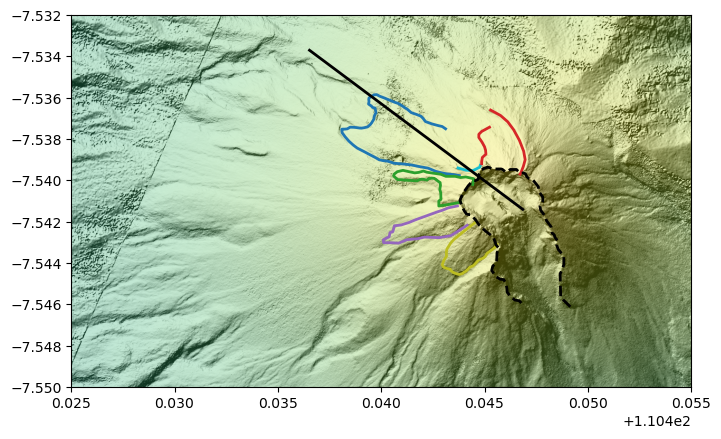

In [7]:
plt.close('all')

lon_lims = [110.425, 110.455]
lat_lims = [-7.550, -7.532]

# L1888
start = [110.43653, -7.53370]
end   = [110.44685, -7.54140]

# # above L1931
# start = [110.42771, -7.53870]
# end   = [110.44997, -7.54170]

fig, ax = plt.subplots(1,1, figsize=(8,8))

ax.imshow(SHADING,extent=DEM_extent, cmap='Greys_r')
ax.imshow(DEM,extent=DEM_extent, cmap='viridis',alpha=0.3)
ax.plot(coords_L1888[:,0],coords_L1888[:,1],linewidth=2,color='tab:blue',label='L1888')
ax.plot(coords_L1948[:,0],coords_L1948[:,1],linewidth=2,color='tab:cyan',label='L1948')
ax.plot(coords_L1956_1[:,0],coords_L1956_1[:,1],linewidth=2,color='tab:red',label='L1956')
ax.plot(coords_L1956_2[:,0],coords_L1956_2[:,1],linewidth=2,color='tab:red')
ax.plot(coords_L1992[:,0],coords_L1992[:,1],linewidth=2,color='tab:purple',label='L1992')
ax.plot(coords_L1997[:,0],coords_L1997[:,1],linewidth=2,color='tab:olive',label='L1997')
ax.plot(coords_L1998[:,0],coords_L1998[:,1],linewidth=2,color='tab:green',label='L1998')
ax.plot(coords_CRATER[:,0],coords_CRATER[:,1],linewidth=2,color='black',linestyle='--',label='Crater rim')
ax.plot([start[0],end[0]],[start[1],end[1]],'-',color='black',linewidth=2)
ax.set_xlim(lon_lims)
ax.set_ylim(lat_lims)

In [13]:
# test functions
%matplotlib osx
plt.close('all')

# L1888
# start = [110.43653, -7.53370]
# end   = [110.44685, -7.54140]

# cross cutting L1888
start = [110.43808, -7.54046]
end   = [110.44221, -7.53412]

# # above L1931
# start = [110.42771, -7.53870]
# end   = [110.44997, -7.54170]

# # on L1931
# start = [110.42623, -7.54107]
# end   = [110.44956, -7.54107]

# # short L1998 
# start = [110.43956, -7.53948]
# end   = [110.44808, -7.54044]

# # gradient on L1956?
# start = [110.43787, -7.53236]
# end   = [110.44723, -7.54066]

# L1992
start = [110.43028, -7.54569]
end   = [110.44802, -7.54006]

# L1992
start = [110.42519, -7.54714]
end   = [110.44802, -7.54006]

# start = [110.43853, -7.54316]
# end   = [110.44598, -7.54081]

# L1956
# start = [110.44625, -7.53457]
# end   = [110.44549, -7.54170]


# define swath
width = 50
dx = 10
line_coords = np.asarray([start,end])
buffer_poly = poly_line_buffer_lat_lon(line_coords,width)

lons_d = lons_DEM.flatten()
lats_d = lats_DEM.flatten()

proj_data_DEM, profile_stats_DEM = get_swath_profile(DEM,lons_d,lats_d,start,end,width=width,dx=dx)



fig, ax = plt.subplots(1,2, figsize=(15,8))

ax[0].imshow(SHADING,extent=DEM_extent, cmap='Greys_r')
elev = ax[0].imshow(DEM,extent=DEM_extent, cmap='viridis',alpha=0.3)
ax[0].plot(coords_L1888[:,0],coords_L1888[:,1],linewidth=2,color='tab:blue',label='L1888')
ax[0].plot(coords_L1948[:,0],coords_L1948[:,1],linewidth=2,color='tab:cyan',label='L1948')
ax[0].plot(coords_L1956_1[:,0],coords_L1956_1[:,1],linewidth=2,color='tab:red',label='L1956')
ax[0].plot(coords_L1956_2[:,0],coords_L1956_2[:,1],linewidth=2,color='tab:red')
ax[0].plot(coords_L1992[:,0],coords_L1992[:,1],linewidth=2,color='tab:purple',label='L1992')
ax[0].plot(coords_L1997[:,0],coords_L1997[:,1],linewidth=2,color='tab:olive',label='L1997')
ax[0].plot(coords_L1998[:,0],coords_L1998[:,1],linewidth=2,color='tab:green',label='L1998')
ax[0].plot(coords_CRATER[:,0],coords_CRATER[:,1],linewidth=2,color='black',linestyle='--',label='Crater rim')
ax[0].plot(np.asarray(buffer_poly.exterior.coords)[:,0],np.asarray(buffer_poly.exterior.coords)[:,1],color='tab:orange')
ax[0].plot([start[0],end[0]],[start[1],end[1]],'-',color='black',linewidth=2)
ax[0].set_xlim(lon_lims)
ax[0].set_ylim(lat_lims)
ax[0].set_axis_off()
ax[0].add_artist(ScaleBar(sm.plot.get_1deg_dist(),location='lower left'))

cax = add_bottom_cax(ax[0],0.04,0.02)
cbar = fig.colorbar(elev,cax= cax, label='Elevation [m]', orientation = 'horizontal', location='bottom')




# fig, ax0 =plt.subplots(constrained_layout=True, figsize=(8,8))
ax[1].fill_between(profile_stats_DEM[:,0], 
                 np.zeros(np.shape(profile_stats_DEM[:,1])),
                 profile_stats_DEM[:,1],
                 color='grey',
                 alpha=0.5)

ax[1].plot(profile_stats_DEM[:,0], profile_stats_DEM[:,1],'-',color='black')
ax[1].set_ylim([2000,3500])
ax[1].set_aspect('equal')
ax[1].set_xlabel('Distance along profile [m]')
ax[1].set_ylabel('Elevation [m]')


proj_data_P1, profile_stats_P1 = get_swath_profile(np.asarray(CSK_Mag_1),CSK_TS['Longitude'],CSK_TS['Latitude'],start,end,width=25,dx=10)
proj_data_P12, profile_stats_P12 = get_swath_profile(np.asarray(CSK_Mag_1+CSK_Mag_2),CSK_TS['Longitude'],CSK_TS['Latitude'],start,end,width=25,dx=10)
proj_data_P13, profile_stats_P13 = get_swath_profile(np.asarray(CSK_Mag_1+CSK_Mag_2+CSK_Mag_3),CSK_TS['Longitude'],CSK_TS['Latitude'],start,end,width=25,dx=10)
proj_data_P14, profile_stats_P14 = get_swath_profile(np.asarray(CSK_Mag_1+CSK_Mag_2+CSK_Mag_3+CSK_Mag_4),CSK_TS['Longitude'],CSK_TS['Latitude'],start,end,width=25,dx=10)
proj_data_P15, profile_stats_P15 = get_swath_profile(np.asarray(CSK_Mag_1+CSK_Mag_2+CSK_Mag_3+CSK_Mag_4+CSK_Mag_5),CSK_TS['Longitude'],CSK_TS['Latitude'],start,end,width=25,dx=10)

ax1 = ax[1].twinx()

ax1.fill_between(profile_stats_P1[:,0], 
                 profile_stats_P1[:,3],
                 profile_stats_P1[:,4],
                 color='tab:orange',
                 alpha=0.5)
ax1.scatter(profile_stats_P1[:,0], profile_stats_P1[:,1],marker='.',color='tab:orange')

ax1.fill_between(profile_stats_P12[:,0], 
                 profile_stats_P12[:,3],
                 profile_stats_P12[:,4],
                 color='tab:blue',
                 alpha=0.5)
ax1.scatter(profile_stats_P12[:,0], profile_stats_P12[:,1],marker='.',color='tab:blue')

ax1.fill_between(profile_stats_P13[:,0], 
                 profile_stats_P13[:,3],
                 profile_stats_P13[:,4],
                 color='tab:red',
                 alpha=0.5)
ax1.scatter(profile_stats_P13[:,0], profile_stats_P13[:,1],marker='.',color='tab:red')

ax1.fill_between(profile_stats_P14[:,0], 
                 profile_stats_P14[:,3],
                 profile_stats_P14[:,4],
                 color='tab:green',
                 alpha=0.5)
ax1.scatter(profile_stats_P14[:,0], profile_stats_P14[:,1],marker='.',color='tab:green')

ax1.fill_between(profile_stats_P15[:,0], 
                 profile_stats_P15[:,3],
                 profile_stats_P15[:,4],
                 color='tab:pink',
                 alpha=0.5)
ax1.scatter(profile_stats_P15[:,0], profile_stats_P15[:,1],marker='.',color='tab:pink')

ax1.set_ylabel('Displacement magnitude [m]')
# ax1.set_ylim([-0.2,3])


ax[0].legend(loc='upper left', borderaxespad=0., frameon=True)

number of points in swath profile: 5219
number of points in swath profile: 414


/var/folders/7b/9xvft5dd0455jpkm_r7rgr3w0000gp/T/ipykernel_46242/3304836431.py:137: RuntimeWarning: Mean of empty slice
  np.nanmean(proj_data[sel,3]),
/Users/tz20896/anaconda3/envs/PhD_clean/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/Users/tz20896/anaconda3/envs/PhD_clean/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1555: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


number of points in swath profile: 414


/var/folders/7b/9xvft5dd0455jpkm_r7rgr3w0000gp/T/ipykernel_46242/3304836431.py:137: RuntimeWarning: Mean of empty slice
  np.nanmean(proj_data[sel,3]),
/Users/tz20896/anaconda3/envs/PhD_clean/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/Users/tz20896/anaconda3/envs/PhD_clean/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1555: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


number of points in swath profile: 414


/var/folders/7b/9xvft5dd0455jpkm_r7rgr3w0000gp/T/ipykernel_46242/3304836431.py:137: RuntimeWarning: Mean of empty slice
  np.nanmean(proj_data[sel,3]),
/Users/tz20896/anaconda3/envs/PhD_clean/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/Users/tz20896/anaconda3/envs/PhD_clean/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1555: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


number of points in swath profile: 414


/var/folders/7b/9xvft5dd0455jpkm_r7rgr3w0000gp/T/ipykernel_46242/3304836431.py:137: RuntimeWarning: Mean of empty slice
  np.nanmean(proj_data[sel,3]),
/Users/tz20896/anaconda3/envs/PhD_clean/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/Users/tz20896/anaconda3/envs/PhD_clean/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1555: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


number of points in swath profile: 414


/var/folders/7b/9xvft5dd0455jpkm_r7rgr3w0000gp/T/ipykernel_46242/3304836431.py:137: RuntimeWarning: Mean of empty slice
  np.nanmean(proj_data[sel,3]),
/Users/tz20896/anaconda3/envs/PhD_clean/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/Users/tz20896/anaconda3/envs/PhD_clean/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1555: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


: 

In [197]:

width_swath = 25 # m
start_base = ... # starting point for profile baseline
end_base = ... # end point for profile baseline
print(f'query line: {start_base}, {end_base}\nWidth:  {width_swath} m')

# start_base = [110.4405519,-7.5337943] # starting point for profile baseline
# end_base = [110.4442428,-7.5371901] # end point for profile baseline


line_coords = np.asarray([start_base,end_base])
buffer_poly = poly_line_buffer_lat_lon(line_coords,width_swath)


fig, ax0 =plt.subplots(constrained_layout=True, figsize=(15,10))
ax0.imshow(shading,cmap=cm.grayC,alpha=0.5, extent=DEM_extent)
ax0.imshow(np.reshape(rdisp_q,[height,width]),cmap=cm.vik,alpha=0.9,vmin=-vmax,vmax=vmax, extent=rdisp_extent)
ax0.plot(np.asarray(buffer_poly.exterior.coords)[:,0],np.asarray(buffer_poly.exterior.coords)[:,1])
ax0.plot(np.asarray(line_coords)[:,0],np.asarray(line_coords[:,1]))
ax0.set_xlim([110.425, 110.47])
ax0.set_ylim([-7.56, -7.525])
# ax0.axis('equal')

plt.show()

query line: Ellipsis, Ellipsis
Width:  25 m


TypeError: 'ellipsis' object is not iterable